# Machine Learning for physicists

## TP0 : Introduction to Python

In [1]:
#! /usr/bin/env python3
# Coraline Letouze 25 Sept 2020
# Machine Learning for physicists
# TP0: Introduction to Python
# Exercice2: Stochastic Agent

In [2]:
from numpy import exp, sqrt, pi, var
from numpy import random

In [3]:
class Agent:
    """
    A simple class which defines an `agent`, some decision making 
    entity which wants to maximize its own reward.
    """    
    def __init__(self, utility=0, position=(0.0,0.0),
                 utility_func = None, step_size = 1.0):
        """
        The initialization function gets called by the interpreter 
        every time a new object of the Agent class gets created.
            
        :param utility: Agent's current utility value.
        :param utility_func: Function with which to evaluate the utility
        of the agent. The funciton `utility_func` takes an (x,y) coor-
        dinate and reports a utility.
        :param position: Agent's current position (x,y)    
        """
        self.utility = utility
        self.position = position
        self.utility_func = utility_func
        self.history = dict(position = [], utility = [])
        self.step_size = step_size
    
    def __repr__(self):
        """
        This function gets called whenever the interpreter needs a 
        "formal" string representation (error logs, etc.)
        """
        return "Agent<p:%s, u:%s>" %(self.position, self.utility)
    
    def __str__(self):
        """
        This function gets called by the interpreter whenever there 
        needs to be a "user friendly"  string description of the 
        Agent object (e.g. `print(Agent())`).
        """
        return "Agent @ %s [u=%s]" % (self.position, self.utility)
    
    def record_state(self):
        """
            Store the current state of the agent in a queue.
        """
        self.history['position'].append(self.position)
        self.history['utility'].append(self.utility)
    
    def move_up(self):
        """
            Increment the Y coordinate of the agent.
        """
        self.record_state()
        self.position = (self.position[0], 
                         self.position[1]+self.step_size)
        self.utility = self.evaluate_utility()
        
    def move_down(self):
        """
        Decrement the Y coordinate of the agent.
        """
        self.record_state()
        self.position = (self.position[0], 
                         self.position[1]-self.step_size)
        self.utility = self.evaluate_utility()
        
    def move_left(self):
        """
        Decrement the X coordinate of the agent
        """
        self.record_state()
        self.position = (self.position[0]-self.step_size,
                         self.position[1])
        self.utility = self.evaluate_utility()
        
    def move_right(self):
        """
        Increment the X coordinate of the agent
        """
        self.record_state()
        self.position = (self.position[0]+self.step_size,
                         self.position[1])
        self.utility = self.evaluate_utility()
        
    def evaluate_utility(self, offset=(0.0, 0.0)):
        """
        Get the utility function relative to the current agent location.
        Optinally, evaluate at some offset from the agent.
            
        :param offset: Tuple of (x,y) coordinates with which to offset 
        the agent position to evaluate the utility.
        :return: A numeric value for the utility at the evaluated point
        """
        if self.utility_func == None:
            return 0   # Simple Agent with simple utility
        else:
            return self.utility_func((self.position[0]+offset[0],
                                      self.position[1]+offset[1]))


In [4]:
class StochasticClimber(Agent):    # Inherit from class Agent
    """
    The agent tries to find a global maximum 
    for its utility with stochasticity.
    """
    
    def stepper(self, direction):
        """ 
        Move the agent on the grid in the chosen direction. 
        """
        if direction == 'North':
            self.move_up()
        elif direction == 'East':
            self.move_right()
        elif direction == 'South':
            self.move_down()
        elif direction == 'West':
            self.move_left()
        else:
            pass
        return None
        
    def climb(self, steps):
        """ 
        Move the agent in a random direction, with a probability 
        proportionnal to the utility. 
        """
        for step in range(steps):
            utility_list = [self.evaluate_utility((self.step_size, 0)), # East
                           self.evaluate_utility((-self.step_size, 0)), # West
                           self.evaluate_utility((0, self.step_size)),  # North
                           self.evaluate_utility((0, -self.step_size))] # South
            normalisation_cst = sum(utility_list) # greater than 0 
            probability_list = [utility/normalisation_cst for utility in utility_list]
            chosen_direction = random.choice(['East', 'West', 'North', 'South'], 
                                             p=probability_list)
            self.stepper(chosen_direction)
        return None

In [5]:
def gaussian_utility(position, mean=(0.0,0.0), sig=1.0):
    """
    A simple utility function, essentially just an iid  multivariate normal.
    """
    # Get the variance
    v = sig**2
    # Calculate distance from mean
    d = (position[0] - mean[0], position[1] - mean[1])
    dTd = d[0]**2/v + d[1]**2/v
    # Scaling
    scale = 1/(2*pi*v)
    # Final computation
    utility = scale * exp(-0.5 * dTd)
    utility += 1e-12   
    return utility

In [6]:
# Make a toy utility landscape
mountain_range = lambda p : gaussian_utility(p, mean=(2.0,2.0), sig = 0.1) + \
                            gaussian_utility(p, mean=(2.0,3.0), sig = 0.5) + \
                            gaussian_utility(p, mean=(1.0,1.0), sig = 0.5) + \
                            gaussian_utility(p, mean=(3.0,1.0), sig = 0.5)

In [7]:
# Initialize a StochasticClimber Agent and make it 
# move around in the utility landscape
yves = StochasticClimber(utility_func=mountain_range, step_size=0.05)
yves.climb(steps=40000)

### Saving generated data in CSV format

In [8]:
import pandas as pd

In [9]:
# Create a new dictionary whose keys represent the
# headers (colums) of information that we would like to store
# in the CSV file
yves_csv = dict(x=[], y=[], z=[])
yves_csv['x'] = [yves.history['position'][i][0] for i in
                range(0, len(yves.history['position']))]
yves_csv['y'] =  [yves.history['position'][i][1] for i in
                 range(0, len(yves.history['position']))]
yves_csv['z'] = yves.history['utility']

# Create a DataFrame object from a dictionary
df = pd.DataFrame.from_dict(yves_csv)
# Write to CSV format
df.to_csv("yves.csv", sep=",", header=True, index=False)

# Visualization of the StochasticClimber's trajectory

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# Load data
yvesDF = pd.read_csv('yves.csv')

Text(0.5, 0.92, "Agent's path")

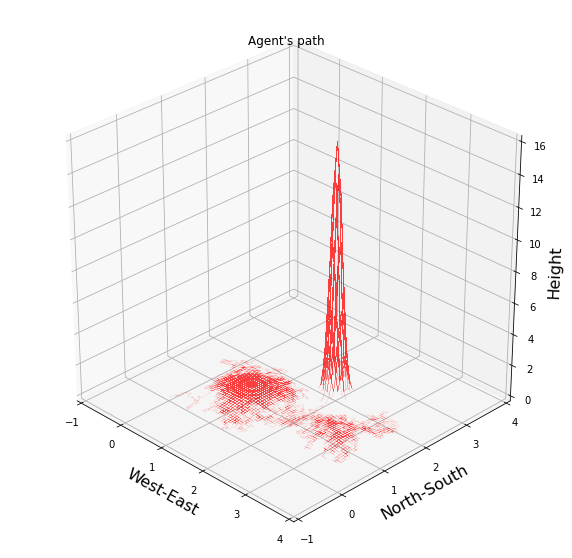

In [12]:
# Plot the Agent's path
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(yvesDF['x'], yvesDF['y'], yvesDF['z'], 'r', linewidth=0.1,
        alpha=0.75, label='Yves')
plt.xlim((-1, 4))
plt.ylim((-1, 4))
ax.view_init(30, -45)

# Axe labels
ax.set_xlabel('West-East', fontsize=16)
ax.set_ylabel('North-South', fontsize=16)
ax.set_zlabel('Height', fontsize=16)
plt.title("Agent's path")

Text(0.5, 1.0, 'Dwell Time, Vertical')

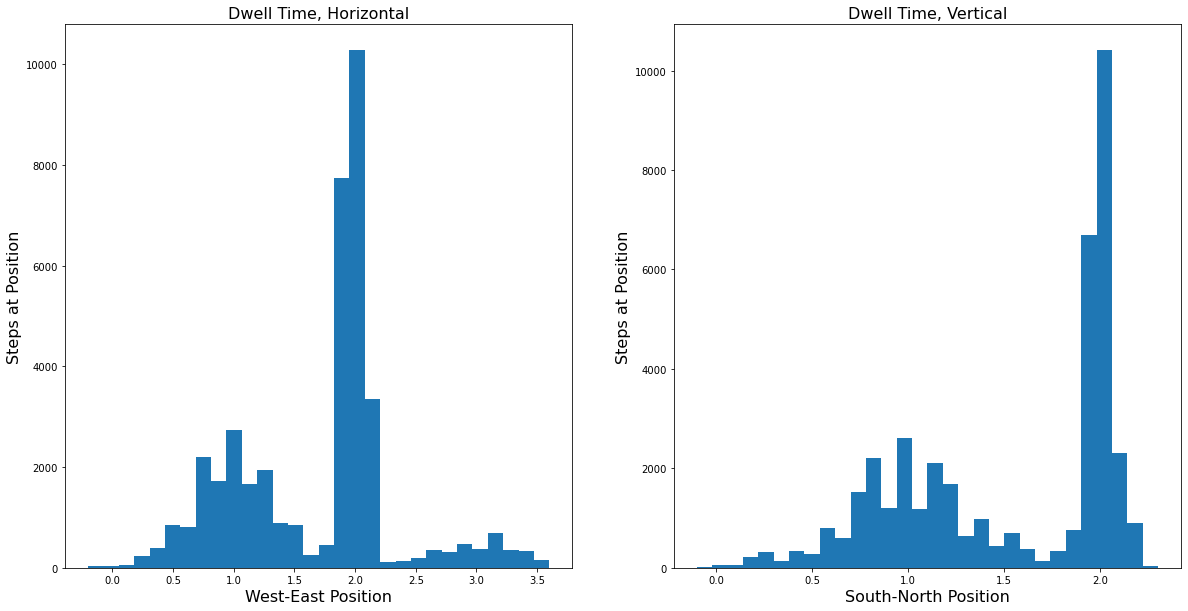

In [13]:
plt.figure(figsize=(20, 10))
    
# Histogram of X locations
plt.subplot(121)
plt.hist(yvesDF['x'], bins=30)
plt.xlabel('West-East Position', fontsize=16)
plt.ylabel('Steps at Position', fontsize=16)
plt.title('Dwell Time, Horizontal', fontsize=16)

# Histogram of Y locations
plt.subplot(122)
plt.hist(yvesDF['y'], bins=30)
plt.xlabel('South-North Position', fontsize=16)
plt.ylabel('Steps at Position', fontsize=16)
plt.title('Dwell Time, Vertical', fontsize=16)

Text(0.5, 1.0, "Position compared to the Tallest Peak's location")

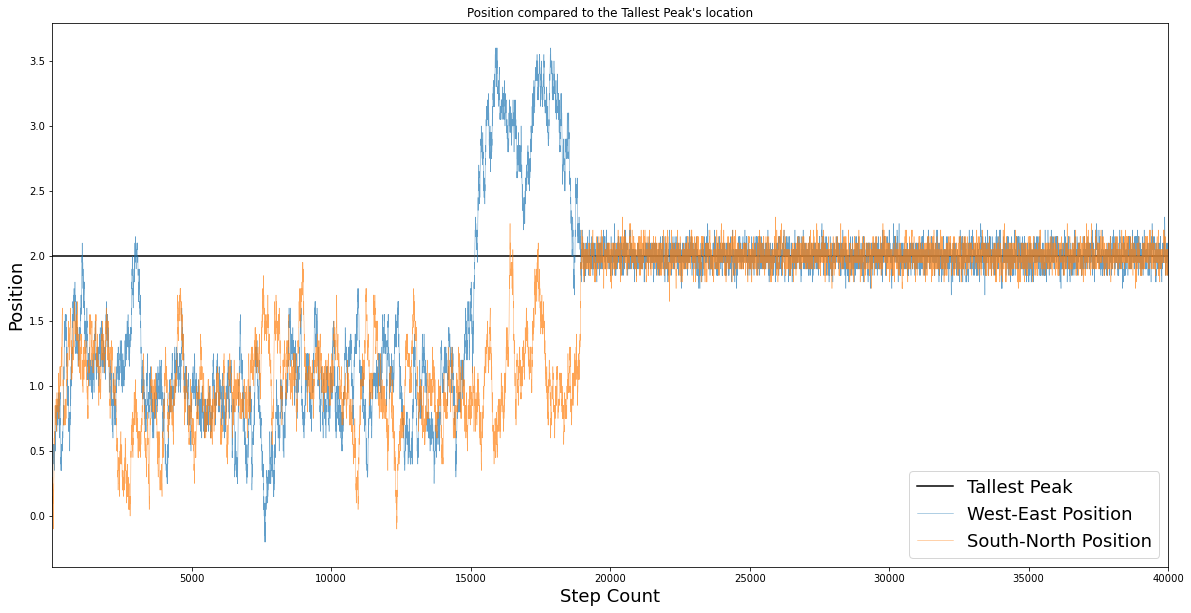

In [14]:
# The Agent's position compared to the Tallest Peak location
maxstep = len(yvesDF['x'])
plt.figure(figsize=(20, 10))
plt.plot([0, maxstep], [2, 2], 'k', label='Tallest Peak')
plt.plot(yvesDF['x'], linewidth=0.5, label='West-East Position',
        alpha=0.7)
plt.plot(yvesDF['y'], linewidth=0.5, label='South-North Position',
        alpha=0.7)
plt.xlim([1, maxstep])
plt.xlabel('Step Count', fontsize=18)
plt.ylabel('Position', fontsize=18)
plt.legend(loc=4, fontsize=18)
plt.title("Position compared to the Tallest Peak's location")

Text(0.5, 1.0, 'Distance to the Tallest Peak')

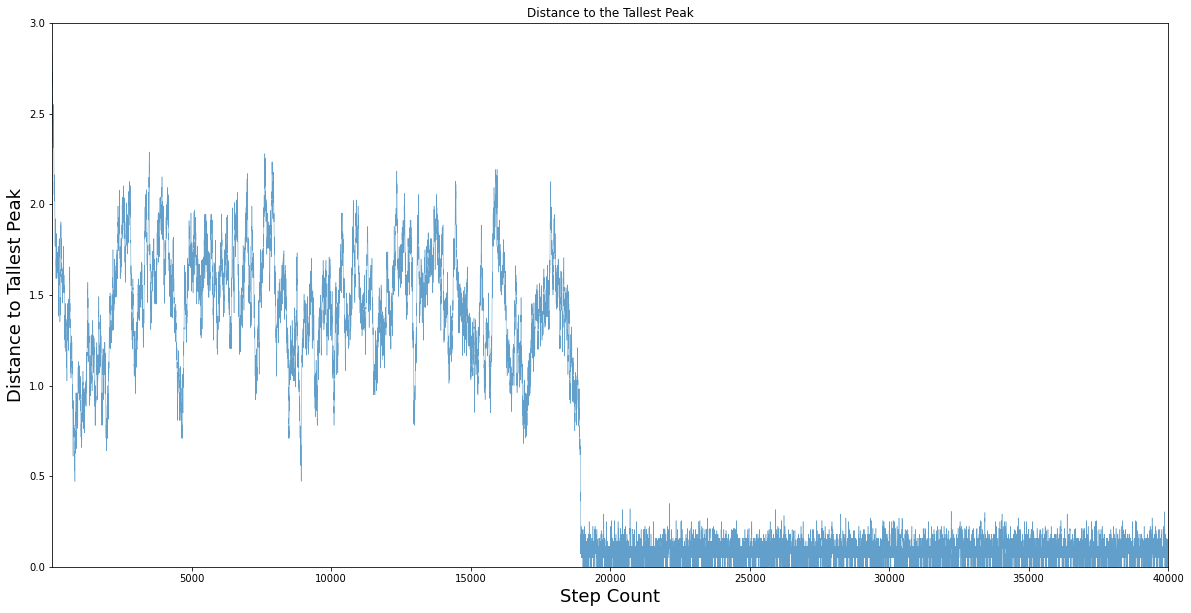

In [15]:
# The Agent's Distance to the Tallest Peak
d = sqrt((yvesDF['x']-2)**2 + (yvesDF['y']-2)**2)
plt.figure(figsize=(20, 10))
plt.plot(d, linewidth=0.5, alpha=0.7)
plt.xlim([1, maxstep])
plt.ylim([0, 3])
plt.xlabel('Step Count', fontsize=18)
plt.ylabel('Distance to Tallest Peak', fontsize=18)
plt.title("Distance to the Tallest Peak")

In [16]:
sqrt(var(d[25000:]))

0.050685657276086656

### Remark

The highest peak here is much taller than the others and its slopes are steep. Tweaking the utility landscape shows that StochasticClimber is not as successful with gentle slopes.